In [42]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import pydotplus
from sklearn import tree
from IPython.display import Image
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [2]:
df = pd.read_csv('train_pronto.csv')

In [3]:
df.drop(['Unnamed: 0', 'weekend'], axis = 1, inplace = True)

In [4]:
class_name = 'Occupancy'

In [5]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y)

## COMINCIO A SETTARE I PARAMETRI PER LA GRID SEARCH

In [45]:
decisiontree = DecisionTreeClassifier()

In [46]:
pipe = Pipeline(steps=[('decisiontree', decisiontree)])

In [47]:
n_components = list(range(1,X_train.shape[1]+1,1))

In [48]:
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]

In [49]:
parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

In [50]:
clf = GridSearchCV(pipe, parameters, cv = 3)

In [67]:
#Applico gridsearch
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('decisiontree',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                

In [68]:
# VISUALIZZO I PARAMETRI MIGLIORI E LO SCORING CON LA CROSS VALIDATION CONSIDERANDO MEDIA E DEV. STD

In [54]:
# View The Best Parameters
print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
print(); print(clf.best_estimator_.get_params()['decisiontree'])

# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X_train, y_train, cv=3, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Criterion: entropy
Best max_depth: 10

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[0.98965705 0.98856521 0.99101552]

0.9897459245803125

0.0010023082182393523


In [69]:
# CREO IL DECISION TREE

In [55]:
dt = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
dt = dt.fit(X_train, y_train)

C:\Users\Ale\anaconda3\lib\site-packages\sklearn\tree\_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


In [56]:
X_test = df.drop(['Occupancy'], axis=1)

In [57]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

In [70]:
#IMPORTANZA COLONNE

In [58]:
for col, imp in zip(X_test.columns, dt.feature_importances_):
    print(col, imp)
    
cols = [(col) for col, imp in zip(X_test.columns, dt.feature_importances_) if imp == 0]
print(cols)

Temperature 0.013387700158691875
Humidity 0.016354920687264553
Light 0.9460302833175293
CO2 0.016921947071025813
HumidityRatio 0.006543427013811634
afternoon 0.00043748555398614314
morning 0.00032423619769074744
evening 0.0
night 0.0
cat_weekend 0.0
cat_weekday 0.0
['evening', 'night', 'cat_weekend', 'cat_weekday']


In [71]:
#VISUALIZZO IL DECISION TREE

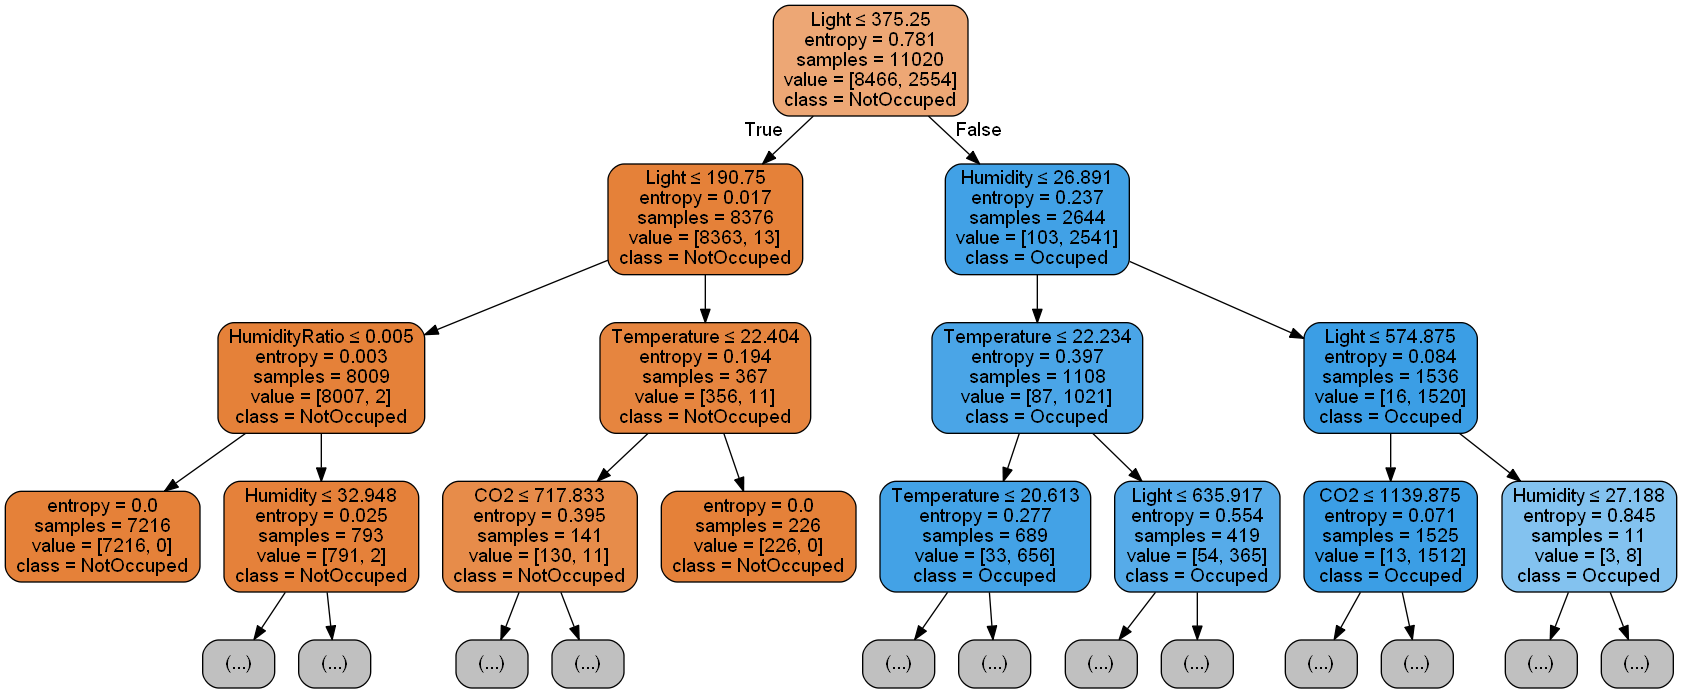

In [59]:
dot_data = tree.export_graphviz(dt, out_file=None,
                                feature_names=X_test.columns,
                                class_names=['Occuped' if x == 1 else 'NotOccuped' for x in dt.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [60]:
y_test = df.Occupancy

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average='binary', pos_label=0))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s\n' % f1_score(y_test, y_pred, pos_label=0))

print('Classification report train:')
print(classification_report(y_train, y_pred_tr))

print('Classification report test:')
print(classification_report(y_test, y_pred))

print('precision recall f1 support:')
print(precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=0))
print()

print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred_tr))

Train Accuracy 0.9980036297640653
Train F1-score 0.9986994561362024

Test Accuracy 0.9953793774319066
Test F1-score 0.9969908140639847

Classification report train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8466
           1       0.99      1.00      1.00      2554

    accuracy                           1.00     11020
   macro avg       1.00      1.00      1.00     11020
weighted avg       1.00      1.00      1.00     11020

Classification report test:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12636
           1       0.99      0.99      0.99      3812

    accuracy                           1.00     16448
   macro avg       0.99      0.99      0.99     16448
weighted avg       1.00      1.00      1.00     16448

precision recall f1 support:
(0.9976228209191759, 0.9963596074707186, 0.9969908140639847, None)

Confusion matrix:
[[8447   19]
 [   3 2551]]


## PROFONDITA' MASSIMA CON AUC E F1 SCORE

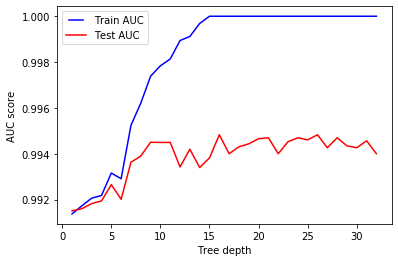

In [61]:

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

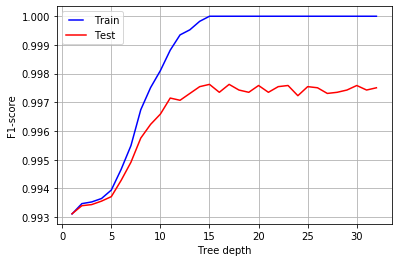

In [62]:

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   f1_train=f1_score(y_train, train_pred, average= 'binary', pos_label=0)
   train_results.append(f1_train) 
   
   y_pred = dt.predict(X_test)
   f1_test=f1_score(y_test, y_pred, average='binary', pos_label=0)
   test_results.append(f1_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train")
line2, = plt.plot(max_depths, test_results, 'r', label="Test")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.grid()
plt.ylabel('F1-score')
plt.xlabel('Tree depth')
plt.show()

# roc curve

In [63]:
y_score = dt.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

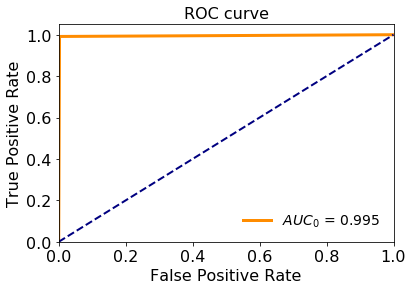

In [64]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# lift charts

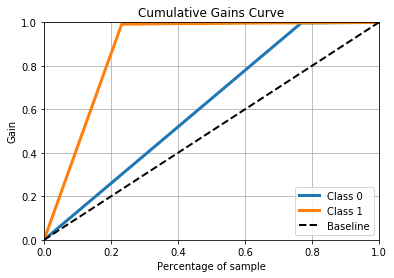

In [65]:
plot_cumulative_gain(y_test, y_score)
plt.show()

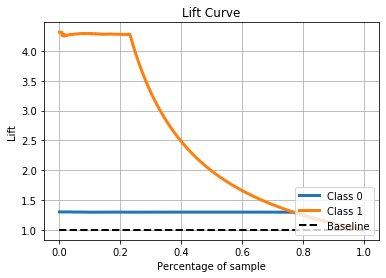

In [66]:
plot_lift_curve(y_test, y_score)
plt.show()

In [72]:
'''AGGIUNGO UN COMMENTO PERSONALE... DUNQUE SE SI VEDE L\' ESEMPIO SOTTO PERFORMAVA PEGGIO... 
QUELLO FATTO SOPRA PERFORMA SCHIFOSAMENTE BENE.. PER CUI O C\'è DA RIVEDERE QUALCOSA IN PARTICOLAR MODO PER X_TRAIN
X_TEST Y_TRAIN Y_TEST E Y_PRED OPPURE NON SAPREI DOVE METTERE LE MANI E SBATTERE LA TESTA'''

"AGGIUNGO UN COMMENTO PERSONALE... DUNQUE SE SI VEDE L' ESEMPIO SOTTO PERFORMAVA PEGGIO... \nQUELLO FATTO SOPRA PERFORMA SCHIFOSAMENTE BENE.. PER CUI O C'è DA RIVEDERE QUALCOSA IN PARTICOLAR MODO PER X_TRAIN\nX_TEST Y_TRAIN Y_TEST E Y_PRED OPPURE NON SAPREI DOVE METTERE LE MANI E SBATTERE LA TESTA"

# DA QUI IN POI E' IL FILE PRECEDENTE.. PER CONFRONTARE

In [9]:
pipe = Pipeline([('classifier' , decisiontree)])
criterion = ['gini', 'entropy']
max_depth = [4,6,8]

parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

In [10]:
clf = GridSearchCV(pipe, parameters, cv = 3, n_jobs=-1)

In [11]:
#fit on data
best_clf = clf.fit(X_train, y_train)

ValueError: Invalid parameter decisiontree for estimator Pipeline(memory=None,
         steps=[('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [21]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [8]:
n_components = list(range(1,X_train.shape[1]+1,1))

In [9]:
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10]

In [10]:
parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

In [14]:
clf = GridSearchCV(pipe, parameters)

In [15]:
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sc',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('decisiontree',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                             

In [16]:
# View The Best Parameters
print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
# print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['decisiontree'])

# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X_train, y_train, cv=3, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Criterion: gini
Best max_depth: 8

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[0.99020142 0.98802069 0.99101552]

0.9897458751778426

0.0012643535903053402


### DECISION TREE CON I PARAMETRI TROVATI DA GRID SEARCH

In [12]:
clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
clf = clf.fit(X_train, y_train)

In [115]:
X_test = test.drop(['Occupancy'], axis=1)

In [117]:
X_test.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,afternoon,morning,evening,night,cat_weekend,cat_weekday
0,21.7600,31.133333,437.333333,1029.666667,0.005021,1,0,0,0,0,1
1,21.7900,31.000000,437.333333,1000.000000,0.005009,1,0,0,0,0,1
2,21.7675,31.122500,434.000000,1003.750000,0.005022,1,0,0,0,0,1
3,21.7675,31.122500,439.000000,1009.500000,0.005022,1,0,0,0,0,1
4,21.7900,31.133333,437.333333,1005.666667,0.005030,1,0,0,0,0,1


In [13]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

NameError: name 'X_test' is not defined

In [118]:
for col, imp in zip(X_test.columns, clf.feature_importances_):
    print(col, imp)
    
cols = [(col) for col, imp in zip(X_test.columns, clf.feature_importances_) if imp == 0]
print(cols)

Temperature 0.014180048163238743
Humidity 0.0014153527226623513
Light 0.9576517011683278
CO2 0.014185718292739815
HumidityRatio 0.005959048872714538
afternoon 0.0
morning 0.0
evening 0.0
night 0.0
cat_weekend 0.006608130780316699
cat_weekday 0.0
['afternoon', 'morning', 'evening', 'night', 'cat_weekday']


In [119]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_test.columns,
                                class_names=['IsBadBuy' if x == 1 else 'IsNotBadBuy' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [120]:
y_test = test.Occupancy

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average='binary', pos_label=0))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s\n' % f1_score(y_test, y_pred, pos_label=0))

print('Classification report train:')
print(classification_report(y_train, y_pred_tr))

print('Classification report test:')
print(classification_report(y_test, y_pred))

print('precision recall f1 support:')
print(precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=0))
print()

print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred_tr))

Train Accuracy 0.9957904583723106
Train F1-score 0.9957792715335314

Test Accuracy 0.9532093098171861
Test F1-score 0.9686708007549204

Classification report train:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6414
           1       0.99      1.00      1.00      6414

    accuracy                           1.00     12828
   macro avg       1.00      1.00      1.00     12828
weighted avg       1.00      1.00      1.00     12828

Classification report test:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      9396
           1       0.87      0.94      0.91      3021

    accuracy                           0.95     12417
   macro avg       0.93      0.95      0.94     12417
weighted avg       0.96      0.95      0.95     12417

precision recall f1 support:
(0.9817466389769374, 0.9559386973180076, 0.9686708007549204, None)

Confusion matrix:
[[6370   44]
 [  10 6404]]


## CROSS VALIDATION... boooohh

In [81]:
from sklearn.model_selection import cross_val_score

In [82]:
scores = cross_val_score(clf, X_train, y_train, cv=100)
scores

array([0.99224806, 1.        , 1.        , 1.        , 0.87596899,
       0.99224806, 1.        , 1.        , 0.99224806, 1.        ,
       1.        , 1.        , 0.8372093 , 0.68992248, 0.98449612,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99224806, 1.        , 1.        , 1.        ,
       0.99224806, 0.93023256, 0.95348837, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.796875  , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9921875 , 1.        , 0.9921875 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [83]:
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
scores

array([0.97270624, 0.99337473, 0.94488424, 0.96565249, 0.59909541])

In [84]:
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_micro')
scores

array([0.9731099 , 0.9933749 , 0.94505066, 0.96569201, 0.95204678])

In [85]:
scores = cross_val_score(clf, X_train, y_train, cv=100, scoring='f1')
scores

array([0.99224806, 1.        , 1.        , 1.        , 0.85964912,
       0.99224806, 1.        , 1.        , 0.99224806, 1.        ,
       1.        , 1.        , 0.86092715, 0.76470588, 0.98461538,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99212598, 1.        , 1.        , 1.        ,
       1.        , 0.93430657, 0.95522388, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.83116883, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99212598, 1.        , 0.99212598, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

### TUNING DEI PARAMETRI: profondità massima con AUC e f1 score

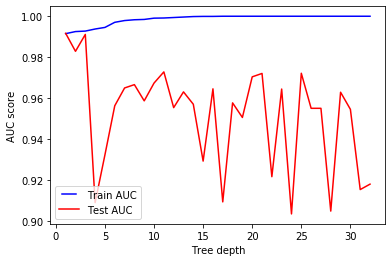

In [121]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

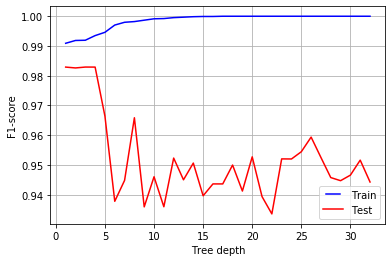

In [87]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   f1_train=f1_score(y_train, train_pred, average= 'binary', pos_label=0)
   train_results.append(f1_train) 
   
   y_pred = dt.predict(X_test)
   f1_test=f1_score(y_test, y_pred, average='binary', pos_label=0)
   test_results.append(f1_test)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train")
line2, = plt.plot(max_depths, test_results, 'r', label="Test")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.grid()
plt.ylabel('F1-score')
plt.xlabel('Tree depth')
plt.show()

## ROC CURVE

In [90]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

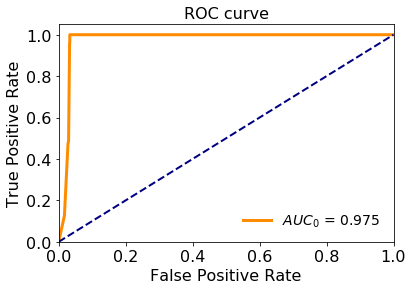

In [91]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()